Some preliminary code:

In [530]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

def ShowImage(title,img,ctype):
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.title(title)
  plt.show()

For reference, here's your original image:

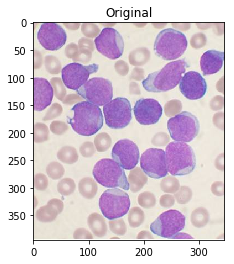

In [319]:
#Read in image
img         = cv2.imread('cells.jpg')
ShowImage('Original',img,'bgr')

The article you've linked to suggests using [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) for colour segmentation. The method assumes that the intensity of the pixels of the image can be plotted into a bimodal histogram, and finds an optimal separator for that histogram. I apply the method below.

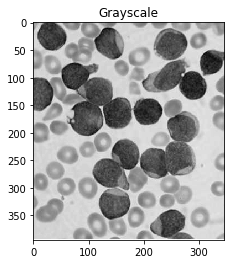

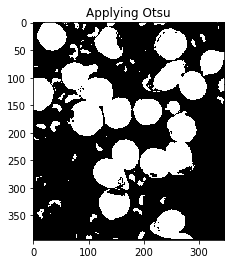

In [348]:
#Convert to a single, grayscale channel
gray        = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ShowImage('Grayscale',gray,'gray')
ShowImage('Applying Otsu',thresh,'gray')

The binary form of the image isn't that good! Looking at the grayscale image, you can see why: the Otsu transformation produces _three_ classes of pixels: the dark background pixels, the donut cells and cell interiors, and the nuclei. The histogram below demonstrates this:

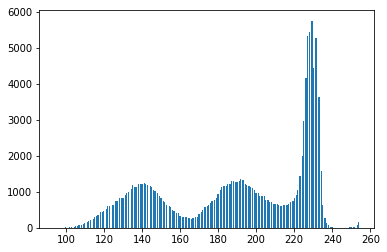

In [136]:
#Make a histogram of the intensities in the grayscale image
plt.hist(gray.ravel(),256)
plt.show()

Thus, you've broken the assumptions of the algorithm you are using, so it's not unexpected that you get bad results. By throwing away colour information, we've lost the ability to differentiate donuts from cell interiors.

One way of dealing with this is to perform segmentation based on colour thresholding. To do this, you choose a color space to work in. [This guide](https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/) has an excellent pictorial description of the different spaces.

Let's choose HSV. This has the advantage that a single channel, `H`, describes the image's colour. Once we've converted our image into this space, we can find the bounds of our colours of interest. For instance, to find the cell's nuclei we could do as follows:

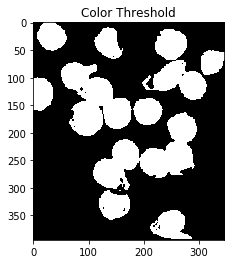

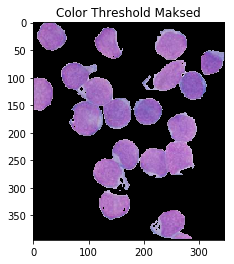

In [349]:
cell_hsvmin  = (110,40,145)  #Lower end of the HSV range defining the nuclei
cell_hsvmax  = (150,190,255) #Upper end of the HSV range defining the nuclei
#Transform image to HSV color space
hsv          = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) 
#Threshold based on HSV values
color_thresh = cv2.inRange(hsv, cell_hsvmin, cell_hsvmax) 
ShowImage('Color Threshold',color_thresh,'gray')

masked = cv2.bitwise_and(img,img, mask=color_thresh)
ShowImage('Color Threshold Maksed',masked,'bgr')

This looks much better! Though, notice that some portions of the cell's interiors are being labeled as nucleii, even though they should not. One could also argue that it's not very automatic: you still have to _carefully_ handpick your colours. Operating in HSV space eliminates a lot of the guesswork, but maybe we could use the fact that there are four distinct colours to obviate the need for ranges! To do so, we pass our HSV pixels through a [k-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering).

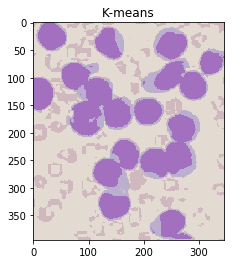

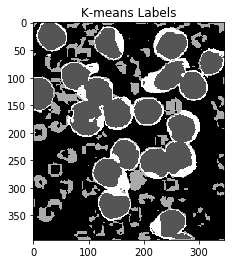

In [545]:
#Convert pixel space to an array of triplets. These are vectors in 3-space.
Z = hsv.reshape((-1,3)) 
#Convert to floating point
Z = np.float32(Z)
#Define the K-means criteria, these are not too important
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#Define the number of clusters to find
K = 4
#Perform the k-means transformation. What we get back are:
#*Centers: The coordinates at the center of each 3-space cluster
#*Labels: Numeric labels for each cluster
#*Ret: A return code indicating whether the algorithm converged, &c.
ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

#Produce an image using only the center colours of the clusters
center = np.uint8(center)
khsv   = center[label.flatten()]
khsv   = khsv.reshape((img.shape))
ShowImage('K-means',khsv,'hsv')

#Reshape labels for masking
label = label.reshape(img.shape[0:2])
ShowImage('K-means Labels',label,'gray')

Notice that this has done an excellent job of separting the colours without the need for manual specification! (Other than specifying the number of clusters.)

Now, we need to figure out which labels correspond to which parts of the cell.

To do so, we find the colour of two pixels: one which is clearly a nucleus pixel and one which is clearly a cell pixel. We then figure out which cluster center is closest to each of these pixels.




In [546]:
#(Distance,Label) pairs
nucleus_colour = np.array([139, 106, 192])
cell_colour    = np.array([130, 41,  207])
nuclei_label  = (np.inf,-1)
cell_label    = (np.inf,-1)
for l,c in enumerate(center):
  print(l,c)
  dist_nuc = np.sum(np.square(c-nucleus_colour)) #Euclidean distance between colours
  if dist_nuc<nuclei_label[0]:
        nuclei_label=(dist_nuc,l)
  dist_cell = np.sum(np.square(c-cell_colour)) #Euclidean distance between colours
  if dist_cell<cell_label[0]:
        cell_label=(dist_cell,l)
nuclei_label = nuclei_label[1]
cell_label   = cell_label[1]
print("Nuclei label={0}, cell label={1}".format(nuclei_label,cell_label))

0 [ 14  20 227]
1 [139 106 192]
2 [173  28 207]
3 [131  40 208]
Nuclei label=1, cell label=3


Now, let's build the binary classifier we need to identify the entirety of the cells for the watershed algorithm:

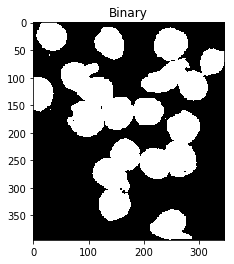

In [355]:
#Multiply by 1 to keep image in an integer format suitable for OpenCV
thresh = cv2.bitwise_or(1*(label==nuclei_label),1*(label==cell_label))
thresh = np.uint8(thresh)
ShowImage('Binary',thresh,'gray')

We can now eliminate single-pixel noise:

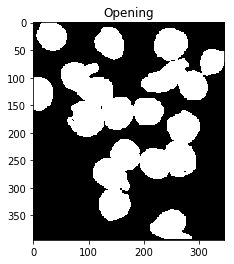

In [399]:
#Remove noise by eliminating single-pixel patches
kernel  = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 2)
ShowImage('Opening',opening,'gray')

We now need to identify the peaks of the watershed and give them separate labels. The goal of this is to generate a set of pixels such that each of the nuclei+cells has a pixel within it and no two nuclei have their identifier pixels touching.

To achieve this, we perform a distance transformation and then filter out distances that are two far from the center of the nuclei+cells.

However, we have to be careful since long, narrow cells with high thresholds might disappear entirely. In the image below, we've separated the two cells that were touching in the bottom right, but entirely eliminated the long, narrow cell that was in the upper right.

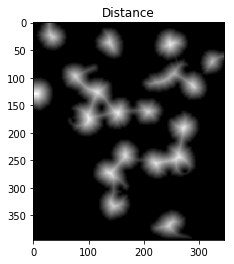

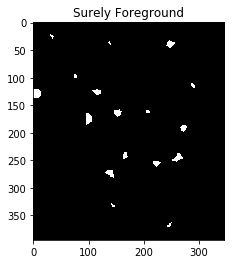

In [520]:
#Identify areas which are surely foreground
fraction_foreground = 0.75
dist         = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist,fraction_foreground*dist.max(),255,0)
ShowImage('Distance',dist_transform,'gray')
ShowImage('Surely Foreground',sure_fg,'gray')

Decreasing the threshold brings the long, narrow cell back, but leaves the cells in the bottom right connected.

We can fix this by using an adaptive method which identifies the peaks in each local area. This eliminates the need to set a single, global constant for our threshold. To do so, we use the `h_axima` function, which returns all local maxima that are greater than a specified cut-off value. This contrasts with the distance function, which returned all pixels greater than a given value.

/usr/lib/python3/dist-packages/skimage/morphology/extrema.py:111: FutureWarning: Conversion of the second argument of issubdtype from `'half'` to `np.floating` is deprecated. In future, it will be treated as `np.float16 == np.dtype('half').type`.
  if np.issubdtype(img.dtype, 'half'):


Peaks found: 23


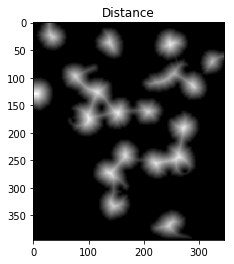

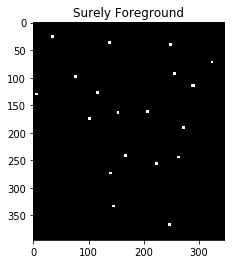

In [512]:
#Identify areas which are surely foreground
h_fraction = 0.1
dist     = cv2.distanceTransform(opening,cv2.DIST_L2,5)
maxima   = extrema.h_maxima(dist, h_fraction*dist.max())
print("Peaks found: {0}".format(np.sum(maxima)))
#Dilate the maxima so we can see them
maxima   = cv2.dilate(maxima, kernel, iterations=2)
ShowImage('Distance',dist_transform,'gray')
ShowImage('Surely Foreground',maxima,'gray')

Now we identify unknown regions by subtracting off the maxima:

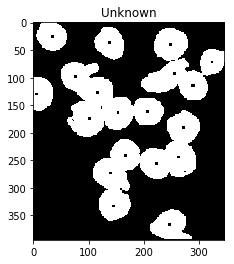

In [535]:
# Finding unknown region
unknown = cv2.subtract(opening,maxima)
ShowImage('Unknown',unknown,'gray')

Next, we give each of the maxima unique labels and then mark the unknown regions before finally performing the watershed transform:

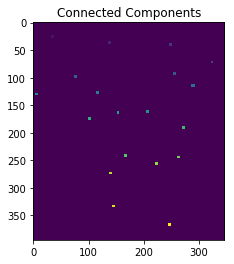

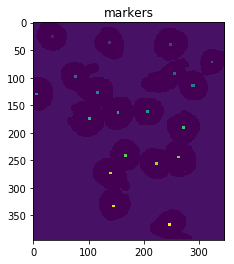

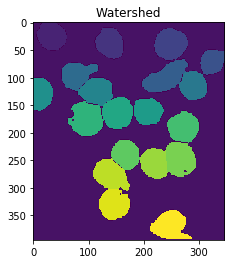

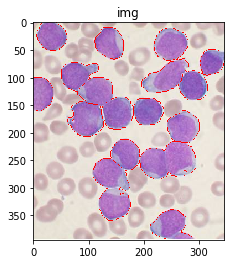

In [536]:
# Marker labelling
ret, markers = cv2.connectedComponents(maxima)
ShowImage('Connected Components',markers,'rgb')

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==np.max(unknown)] = 0

ShowImage('markers',markers,'rgb')

dist    = cv2.distanceTransform(opening,cv2.DIST_L2,5)
markers = skwater(-dist,markers,watershed_line=True)

ShowImage('Watershed',markers,'rgb')
imgout = img.copy()
imgout[markers == 0] = [0,0,255] #Label the watershed_line

ShowImage('img',imgout,'bgr')

This gives us a set of labeled regions representing the cells. Next, we iterate through these regions, use them as masks on our labeled data, and calculate the fractions:

In [568]:
for l in np.unique(markers):
    if l==0:      #Watershed line
        continue
    if l==1:      #Background
        continue
    #For displaying individual cells
    #temp=khsv.copy()
    #temp[markers!=l]=0
    #ShowImage('out',temp,'hsv')
    temp = label.copy()
    temp[markers!=l]=-1
    nucleus_area = np.sum(temp==nuclei_label)
    cell_area    = np.sum(temp==cell_label)
    print("Nucleus fraction for cell {0} is {1}".format(l,nucleus_area/(cell_area+nucleus_area)))

Nucleus fraction for cell 2 is 0.9002795899347623
Nucleus fraction for cell 3 is 0.7953321364452424
Nucleus fraction for cell 4 is 0.7525925925925926
Nucleus fraction for cell 5 is 0.8151515151515152
Nucleus fraction for cell 6 is 0.6808656818962556
Nucleus fraction for cell 7 is 0.8276481149012568
Nucleus fraction for cell 8 is 0.878500237304224
Nucleus fraction for cell 9 is 0.8342518016108521
Nucleus fraction for cell 10 is 0.9742324561403509
Nucleus fraction for cell 11 is 0.8728733459357277
Nucleus fraction for cell 12 is 0.7968570333461096
Nucleus fraction for cell 13 is 0.8226831716293075
Nucleus fraction for cell 14 is 0.7491039426523297
Nucleus fraction for cell 15 is 0.839096357768557
Nucleus fraction for cell 16 is 0.7589670014347202
Nucleus fraction for cell 17 is 0.8559168925022583
Nucleus fraction for cell 18 is 0.7534142640364189
Nucleus fraction for cell 19 is 0.8036734693877551
Nucleus fraction for cell 20 is 0.7566037735849057
